In [7]:
import specdist as pi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.collections import LineCollection
from matplotlib.ticker import LogLocator
import re
scientific_notation = pi.scientific_notation

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import warnings; warnings.simplefilter('ignore')

path_to_figures = "/Users/boris/Work/SPECTRAL-DISTORTIONS/figures/"

xinj_to_mass = 4.698e-4 #m in ev = 4.698e-4 xinj
#1./4.698e-4*2. = 4257.130693912303

# sd_lib_bare = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('bare',sd_lib_bare)


# sd_lib_lyc = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc',sd_lib_lyc)

# sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)




label_y_firas = r'$y_\mathrm{COBE}=1.5\times 10^{-5}$'
label_mu_firas = r'$\mu_\mathrm{COBE}=9\times 10^{-5}$'
label_fdm = 'Effective Dark Matter Fraction, '+r'$\epsilon f_\mathrm{dm}$'
label_mdm = 'Particle Mass, ' +r'$m_\mathrm{dm}\,\,[\mathrm{eV}]$'
label_xe = 'Free Electron Fraction, '+r'$X_\mathrm{e}$'
label_redshift = 'Redshift, '+r'$z$'
label_mu_dist =  'Chemical Potential, '+r'$\mu$'
label_injection_frequency = "Scaled Injection Frequency, "+ r'$x_{\mathrm{inj,0}}$'
label_scaled_frequency = "Scaled Frequency, "+ r'$x=h\nu/k_{_\mathrm{B}}T_{_\mathrm{CMB}}$'
label_frequency_in_GHz = "Frequency,  "+ r'$\nu \quad [\mathrm{GHz}]$'
label_intensity = "Intensity, "+r'$\Delta I_x \quad [\mathrm{Jy/sr}]$'
label_intensity_kJy = "Intensity, "+r'$\Delta I_x \quad [\mathrm{kJy/sr}]$'
label_injection_energy = "Injection Energy, "+ r'$E_{\mathrm{inj,0}}$' + " [eV]"
xinj_to_Einj = 4.698e-4/2.
label_Gamma = "Decay Rate, "+r"$\Gamma_X\quad[\mathrm{s^{-1}}]$"

label_zX = "Maximum Injection Redshift, "+ r'$z_X$'
sd = pi

label_Gamma_stim = r"$\Gamma_X^\mathrm{stim}/\Gamma_X=[1+2n_\mathrm{Pl}(x_\mathrm{inj})]$"

label_zX = "Maximum Injection Redshift, "+ r'$z_X$'
label_Tau_x = "Lifetime,  "+r'$\tau_X\quad[\mathrm{s}]$'

label_log10Tau_x = "Lifetime,  "+r'$\mathrm{log}_{10}(\tau_X/\,1\mathrm{s})$'
label_Tau_x = "Lifetime,  "+r'$\tau_X\quad[\mathrm{s}]$'
label_log10injection_energy = "Injection Energy, "+ r'$\mathrm{log}_{10}(E_{\mathrm{inj,0}}/\,1\mathrm{eV})$'
label_log10mdm = 'Particle Mass, ' +r'$\mathrm{log}_{10}(m_\mathrm{X}/\,1\mathrm{eV})$'

def get_fdm_constraints_at_Gamma_and_xinj(gamma_p,xinj_p,*args,**kwargs):
    a_lib = kwargs['sd_lib']
    f_dm_fisher = sd.pi_run_fisher_constraints([gamma_p],[xinj_p],**kwargs)
    fdm_value = f_dm_fisher['curves'][0]['fdm'][0]
    #x_asked = np.logspace(np.log10(1e-8),np.log10(1e8),3000)
    #fdm_value = GetSpectra(gamma_p,xinj_p,x_asked,a_lib,get_fisher_fdm='yes',use_edges='yes')["fisher_fdm"]
    fdm_pca_value_ct = np.nan
    fdm_pca_value_rf = np.nan
    if gamma_p < 1e-12:
        # using recfast:
        #f_dm_pca = pi_run_pca_constraints_with_recfast([xinj_p],[gamma_p],fdm_value,**kwargs)
        #fdm_pca_value_rf = f_dm_pca['curves'][0]['fdm'][0]
        
        # using CT:
        z_asked = np.logspace(np.log10(1e-2),np.log10(4000),5000)
        S_xe_history = sd.GetXeHistory(gamma_p,xinj_p,z_asked,a_lib)
        fdm_pca_value_ct = S_xe_history['fdm_pca_lim']
    r_dict = {}
    r_dict['fdm_fisher'] = fdm_value
    r_dict['fdm_Xe_pca_rf'] = fdm_pca_value_rf
    r_dict['fdm_Xe_pca_ct'] = fdm_pca_value_ct
    return r_dict




from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def g_agg(gamma,xinj):
    gagg = 3.57e7*gamma**0.5*xinj**(-3./2.)
    return gagg

g_agg = np.vectorize(g_agg)

def gammaX(gagg,xinj):
    gamma = (gagg/(3.57e7*xinj**(-3./2.)))**2.
    return gamma
gammaX = np.vectorize(gammaX)

In [12]:
# load the results
case = 'lyc+reio'
name_ext = ''
add_edges = 'no'
if case == 'lyc+reio':
     name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
name_ext += '_extended_run_high_xinj_260920_no_edges'

#name_ext += '_test'
path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Einj_in_ev' + name_ext + '.txt'
Xf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Tau_X_in_s' + name_ext + '.txt'
Yf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_f_dm' + name_ext + '.txt'
Zf = np.loadtxt(path)

import math
for i in range(200):
    Zf[:,i] = [-5 if math.isnan(x) else x for x in Zf[:,i]]

tau_values = Yf[:,0]
Einj_values = Xf[0]


xinj_values = 10**Einj_values/xinj_to_Einj

mX_values = np.log10(xinj_to_mass*xinj_values)
gamma_values = np.log10(1./10**tau_values)
gagg_values = np.log10(g_agg(10**gamma_values,xinj_values))

# create an interpolating function fdm(m_X, Gamma_X):
import scipy 
f_at_einj_and_tauinj_no_edges = scipy.interpolate.interp2d(Einj_values, tau_values, Zf,
                                                kind='linear',bounds_error=False,fill_value=np.nan)

In [13]:
# load the results
case = 'lyc+reio'
add_edges = 'yes'
name_ext = ''
if case == 'lyc+reio':
    name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
name_ext += '_extended_run_high_xinj_260920'
#name_ext += '_test'
path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Einj_in_ev' + name_ext + '.txt'
Xf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Tau_X_in_s' + name_ext + '.txt'
Yf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_f_dm' + name_ext + '.txt'
Zf = np.loadtxt(path)

import math
for i in range(200):
    Zf[:,i] = [-5 if math.isnan(x) else x for x in Zf[:,i]]

tau_values = Yf[:,0]
Einj_values = Xf[0]


xinj_values = 10**Einj_values/xinj_to_Einj

mX_values = np.log10(xinj_to_mass*xinj_values)
gamma_values = np.log10(1./10**tau_values)
gagg_values = np.log10(g_agg(10**gamma_values,xinj_values))

# create an interpolating function fdm(m_X, Gamma_X):
import scipy 
f_at_einj_and_tauinj = scipy.interpolate.interp2d(Einj_values, tau_values, Zf,
                                                kind='linear',bounds_error=False,fill_value=np.nan)

In [14]:
# load the results
case = 'lyc+reio'
add_edges = 'yes'
name_ext = ''
if case == 'lyc+reio':
    name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
name_ext += '_extended_run_high_xinj_260920_wpca'
#name_ext += '_test'
path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Einj_in_ev' + name_ext + '.txt'
Xf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Tau_X_in_s' + name_ext + '.txt'
Yf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_f_dm' + name_ext + '.txt'
Zf = np.loadtxt(path)

import math
for i in range(200):
    Zf[:,i] = [-9 if math.isnan(x) else x for x in Zf[:,i]]

tau_values = Yf[:,0]
Einj_values = Xf[0]


xinj_values = 10**Einj_values/xinj_to_Einj

mX_values = np.log10(xinj_to_mass*xinj_values)
gamma_values = np.log10(1./10**tau_values)
gagg_values = np.log10(g_agg(10**gamma_values,xinj_values))

# create an interpolating function fdm(m_X, Gamma_X):
import scipy 
f_at_einj_and_tauinj_wedges_wpca = scipy.interpolate.interp2d(Einj_values, tau_values, Zf,
                                                kind='linear',bounds_error=False,fill_value=np.nan)

In [15]:
Xf_gagg = np.zeros((200, 200))
Yf_gagg = np.zeros((200, 200))
Zf_gagg = np.zeros((200, 200))
Zf_gagg_no_edges = np.zeros((200, 200))
Zf_gagg_with_edges_with_pca = np.zeros((200, 200))

In [16]:
for i in range(200):
    for j in range(200):
        einj = 10**Xf[i][j]
        tau_X = 10**Yf[i][j]
        #fdm  = Zf[i][j]

        xinj = einj/xinj_to_Einj
        Xf_gagg[i][j]=np.log10(xinj_to_mass*xinj)
        gamma = 1./tau_X
        Yf_gagg[i][j]=np.log10(g_agg(gamma,xinj))
        #Zf_gagg[i][j] = fdm
    
    
    
    

In [17]:
# find minimum value of log10 gagg
mymin = min([min(r) for r in Yf_gagg])
print(mymin)
# find maximum value of log10 gagg
mymax = max([max(r) for r in Yf_gagg])
print(mymax)
# All the g_agg values in the range
# have been computed before:
print(gagg_values[0],gagg_values[199], len(gagg_values))
# Xf_gagg contains the masses:
# Xf_gagg = [[m_min,...,m_max],
#              :::::::::::::: ,
#            [m_min,...,m_max],]
# Yf_gagg_new has to contain the g_agg values as follows (in column):
Yf_gagg_new  = np.zeros((200,200))
for i in range(200):
    Yf_gagg_new[:,i] = gagg_values[::-1]

# then we loop over gagg and mX values and compute fdm:
for i in range(200):
    for j in range(200):
        log10mX = Xf_gagg[i][j]
        log10gagg = Yf_gagg_new[i][j]
        # compute lifetime  corresponding to mX and gagg:
        xinj = 10**log10mX/xinj_to_mass
        einj = xinj_to_Einj*xinj
        gamma  = gammaX(10**log10gagg,xinj)
        tauinj = 1./gamma
        fdm = f_at_einj_and_tauinj(np.log10(einj),np.log10(tauinj))
        Zf_gagg[i][j] = fdm
        fdm = f_at_einj_and_tauinj_no_edges(np.log10(einj),np.log10(tauinj))
        Zf_gagg_no_edges[i][j] = fdm
        fdm = f_at_einj_and_tauinj_wedges_wpca(np.log10(einj),np.log10(tauinj))
        Zf_gagg_with_edges_with_pca[i][j] = fdm






-20.391007258721398
14.608992741278602
14.608992741278602 -20.391007258721398 200


In [20]:
ma_values = Xf_gagg[0]
#gagg_values

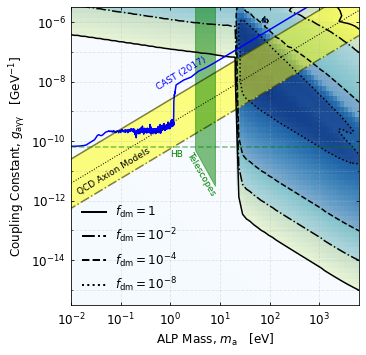

In [46]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
label_size = 12
title_size = 12
legend_size = 25
handle_length = 1.5




#levels = [-8,-4,-2,0]
levels = [-8,-4,-2,0]


colormap = plt.cm.Oranges #or any other colormap
colormap2 = plt.cm.Blues_r
colormap2 = colormap2
normalize = matplotlib.colors.Normalize(vmin=-10, vmax=0)


#CS = ax.contour(Xf_gagg, Yf_gagg_new, Zf_gagg_no_edges,
#                levels,norm=normalize,linestyles=['-','-'],colors=['k','k'],linewidths=[2.9])
#CS = ax.contourf(Xf_gagg, Yf_gagg_new, Zf_gagg_no_edges,
#                levels,extend='min',colors=['w','r'],alpha=0.2)

#CS = ax.contour(Xf_gagg, Yf_gagg_new, Zf_gagg,
#                levels,norm=normalize,linestyles=['--','--'],colors=['k','k'])
#CS = ax.contourf(Xf_gagg, Yf_gagg_new, Zf_gagg,
#                levels,extend='min',colors=['w','r'],alpha=0.2)




CS = ax.contour(Xf_gagg, Yf_gagg_new, Zf_gagg_with_edges_with_pca,
                levels,norm=normalize,
                linestyles=[':','--','-.','-'],
                colors=['k','k']
               )
CS = ax.contourf(Xf_gagg, Yf_gagg_new, Zf_gagg_with_edges_with_pca,
                levels,extend='min',#,colors=['w','orange'],
                 alpha=0.2)




ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)



ax.grid( b=True, which="both", alpha=0.3, linestyle='--')





ax.set_xlabel("ALP Mass, "+r'$m_\mathrm{a}\quad[\mathrm{eV}]$',size=title_size)
ax.set_ylabel("Coupling Constant, "+r'$g_\mathrm{a\gamma\gamma}\quad[\mathrm{GeV}^{-1}]$',size=title_size)
#ax.set_ylabel(label_Tau_x,size=title_size)

ax.yaxis.set_label_coords(-.15,0.5)
ax.xaxis.set_label_coords(0.5,-.09)


# im = ax.imshow(Zf, extent=[Einj_values[0], Einj_values[-1],tau_values[0],tau_values[-1]], origin='lower',
#            cmap=colormap2,norm=normalize, alpha=1.)




#ax.set_xlim(mX_values[0],mX_values[-1])
#ax.set_ylim(tau_values[0],tau_values[-1])
#ax.set_ylim(gagg_values[::-1][0],gagg_values[::-1][-1])




ax.patch.set_color(colormap2(0.99)) # or whatever color you like

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticklabels([r'$10^{-2}$',r'$10^{-1}$',r'$10^{0}$',r'$10^{1}$',r'$10^{2}$',r'$10^{3}$',r'$10^{4}$'])
ax.set_yticklabels([r'$10^{-16}$',r'$10^{-14}$',r'$10^{-12}$',r'$10^{-10}$',r'$10^{-8}$',r'$10^{-6}$'])
CAST = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/cast_env_2016.dat')
m_cast = CAST[:,0]
gagg_cast = CAST[:,1]
ax.plot(np.log10(m_cast)[:-1],np.log10(gagg_cast)[:-1],c='blue',ls='-',lw=1.5)
#ax.fill_between(np.log10(m_cast),np.log10(gagg_cast),np.log10(5.*gagg_cast),color='blue',
#                ls='-',lw=1.)



xinj_values = 10**mX_values/xinj_to_mass


mass_in_eV = np.logspace(-11,9,100)
xinj_am = mass_in_eV/xinj_to_mass

E_over_N_minus_bla = 5./3. - 1.949
#E_over_N_minus_bla = 0.07#2. - 1.949
def f_p(m):
    return (3.4718e24/(E_over_N_minus_bla)**2.)*m**-5

tau = []
for m in mass_in_eV:
    tau.append(f_p(m))
tau_low = np.asarray(tau)
#ax.plot(mass_in_eV ,tau*1e-12,ls = '-')
gamma_low = 1./tau_low

E_over_N_minus_bla = 44./3. - 1.949
def f_p(m):
    return (3.4718e24/(E_over_N_minus_bla)**2.)*m**-5

tau = []
for m in mass_in_eV:
    tau.append(f_p(m))
tau_high = np.asarray(tau)
gamma_high = 1./tau_high

ax.plot(np.log10(mass_in_eV),np.log10(g_agg(gamma_high,xinj_am)),ls='-',c='k',alpha=0.5)
ax.plot(np.log10(mass_in_eV),np.log10(g_agg(gamma_low,xinj_am)),ls='-.',c='k',alpha=0.5)
ax.fill_between(np.log10(mass_in_eV),np.log10(g_agg(gamma_high,xinj_am)),np.log10(g_agg(gamma_low,xinj_am)),
                color='yellow',alpha=0.5)


tau_ksvz = 8.9078e23*mass_in_eV**-5
gamma_ksvz = 1./tau_ksvz

ax.plot(np.log10(mass_in_eV)[(np.log10(mass_in_eV)>-6.6) & (np.log10(mass_in_eV)<-5.9)],
        np.log10(g_agg(gamma_ksvz,xinj_am))[(np.log10(mass_in_eV)>-6.6) & (np.log10(mass_in_eV)<-5.9)],
        c='k',lw=1,ls=':')

ax.plot(np.log10(mass_in_eV)[np.log10(mass_in_eV)>-3.5],
        np.log10(g_agg(gamma_ksvz,xinj_am))[np.log10(mass_in_eV)>-3.5],
        c='k',lw=1,ls=':')





xinj_values = 10**mX_values/xinj_to_mass
gamma = 1e-5
np.log10(g_agg(gamma,xinj_values))
#ax.plot(mX_values,np.log10(g_agg(gamma,xinj_values)),c='grey',label='G=1e-8')
#ax.fill_between(mX_values,np.log10(g_agg(gamma,xinj_values)),15,color='grey',alpha=0.1)


#ax.text(2., 13., 'Vacuum Decay', fontsize=9, verticalalignment='top',
#      bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.4))


im = ax.imshow(Zf_gagg_with_edges_with_pca, 
                extent=[ma_values[0],
                        ma_values[-1],
                        gagg_values[0],
                        
                        gagg_values[-1]],
               #origin='lower',
               cmap=colormap2,norm=normalize, 
               alpha=1.,
               aspect=0.6
              )


custom_lines = [Line2D([0], [0], color='k', lw=2,ls='-'),
                Line2D([0], [0], color='k', lw=2,ls='-.'),
                Line2D([0], [0], color='k', lw=2,ls='--'),
                Line2D([0], [0], color='k', lw=2,ls=':'),
                #Line2D([0], [0], color=cmap(.2), lw=2,ls='--'),
                #Line2D([0], [0], color='k',alpha=0.8,lw=2,ls=':')
               ]
ax.legend(custom_lines, [r'$f_\mathrm{dm}=1$', 
                         r'$f_\mathrm{dm}=10^{-2}$', 
                         r'$f_\mathrm{dm}=10^{-4}$',
                         r'$f_\mathrm{dm}=10^{-8}$',
                        #r'Age of the Universe'
                        ],loc=3,
        fontsize=12,
         frameon = False,
          ncol = 1,
         facecolor='grey',framealpha=0.2)




ax.text(-1.9,-10.18, r'QCD Axion Models' , rotation = 31,
        fontsize=9, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))



ax.text(-0.3,-7.1, r'CAST (2017)' , rotation = 31,
        fontsize=9, color='blue',
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))



ax.axhline(-10.2,c='green',ls='--',alpha=0.5)


ax.text(0.,-10.3, r'HB' , rotation = 0,
        fontsize=9, color='green',
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))

ax.text(0.3,-10.3, r'Telescopes' , rotation = -60,
        fontsize=9, color='green',
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))



ax.fill_between(np.linspace(0.5,0.9,2),np.linspace(-10.3,-11.5,2),-5,color='green',alpha=0.5)

ax.set_ylim(-15.5,-5.5)
ax.set_xlim(-2,3.8)

fig.tight_layout()
#plt.legend()


name_ext = ''
case = 'lyc+reio'
if case == 'lyc+reio':
    name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
else:
    name_ext += '_no_edges'
name_ext += '_extended_run'
name_ext += '_zoomed.pdf'

#plt.title('Standard/Vacuum Decay')
plt.savefig(path_to_figures + '/figures_for_paper_gagg_finally' + name_ext)

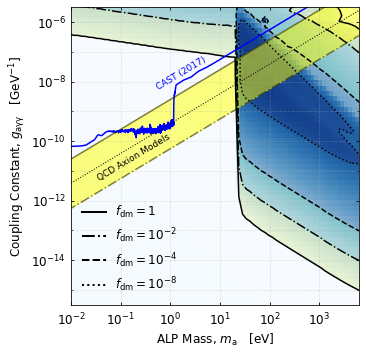

In [244]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
label_size = 12
title_size = 12
legend_size = 25
handle_length = 1.5




#levels = [-8,-4,-2,0]
levels = [-8,-4,-2,0]


colormap = plt.cm.Oranges #or any other colormap
colormap2 = plt.cm.Blues_r
colormap2 = colormap2
normalize = matplotlib.colors.Normalize(vmin=-10, vmax=0)


#CS = ax.contour(Xf_gagg, Yf_gagg_new, Zf_gagg_no_edges,
#                levels,norm=normalize,linestyles=['-','-'],colors=['k','k'],linewidths=[2.9])
#CS = ax.contourf(Xf_gagg, Yf_gagg_new, Zf_gagg_no_edges,
#                levels,extend='min',colors=['w','r'],alpha=0.2)

#CS = ax.contour(Xf_gagg, Yf_gagg_new, Zf_gagg,
#                levels,norm=normalize,linestyles=['--','--'],colors=['k','k'])
#CS = ax.contourf(Xf_gagg, Yf_gagg_new, Zf_gagg,
#                levels,extend='min',colors=['w','r'],alpha=0.2)




CS = ax.contour(Xf_gagg, Yf_gagg_new, Zf_gagg_with_edges_with_pca,
                levels,norm=normalize,
                linestyles=[':','--','-.','-'],
                colors=['k','k']
               )
CS = ax.contourf(Xf_gagg, Yf_gagg_new, Zf_gagg_with_edges_with_pca,
                levels,extend='min',#,colors=['w','orange'],
                 alpha=0.2)




ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)



ax.grid( b=True, which="both", alpha=0.3, linestyle='--')





ax.set_xlabel("ALP Mass, "+r'$m_\mathrm{a}\quad[\mathrm{eV}]$',size=title_size)
ax.set_ylabel("Coupling Constant, "+r'$g_\mathrm{a\gamma\gamma}\quad[\mathrm{GeV}^{-1}]$',size=title_size)
#ax.set_ylabel(label_Tau_x,size=title_size)

ax.yaxis.set_label_coords(-.15,0.5)
ax.xaxis.set_label_coords(0.5,-.09)


# im = ax.imshow(Zf, extent=[Einj_values[0], Einj_values[-1],tau_values[0],tau_values[-1]], origin='lower',
#            cmap=colormap2,norm=normalize, alpha=1.)




#ax.set_xlim(mX_values[0],mX_values[-1])
#ax.set_ylim(tau_values[0],tau_values[-1])
#ax.set_ylim(gagg_values[::-1][0],gagg_values[::-1][-1])




ax.patch.set_color(colormap2(0.99)) # or whatever color you like

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticklabels([r'$10^{-2}$',r'$10^{-1}$',r'$10^{0}$',r'$10^{1}$',r'$10^{2}$',r'$10^{3}$',r'$10^{4}$'])
ax.set_yticklabels([r'$10^{-16}$',r'$10^{-14}$',r'$10^{-12}$',r'$10^{-10}$',r'$10^{-8}$',r'$10^{-6}$'])
CAST = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/cast_env_2016.dat')
m_cast = CAST[:,0]
gagg_cast = CAST[:,1]
ax.plot(np.log10(m_cast)[:-1],np.log10(gagg_cast)[:-1],c='blue',ls='-',lw=1.5)
#ax.fill_between(np.log10(m_cast),np.log10(gagg_cast),np.log10(5.*gagg_cast),color='blue',
#                ls='-',lw=1.)



xinj_values = 10**mX_values/xinj_to_mass


mass_in_eV = np.logspace(-11,9,100)
xinj_am = mass_in_eV/xinj_to_mass

E_over_N_minus_bla = 5./3. - 1.949
#E_over_N_minus_bla = 0.07#2. - 1.949
def f_p(m):
    return (3.4718e24/(E_over_N_minus_bla)**2.)*m**-5

tau = []
for m in mass_in_eV:
    tau.append(f_p(m))
tau_low = np.asarray(tau)
#ax.plot(mass_in_eV ,tau*1e-12,ls = '-')
gamma_low = 1./tau_low

E_over_N_minus_bla = 44./3. - 1.949
def f_p(m):
    return (3.4718e24/(E_over_N_minus_bla)**2.)*m**-5

tau = []
for m in mass_in_eV:
    tau.append(f_p(m))
tau_high = np.asarray(tau)
gamma_high = 1./tau_high

ax.plot(np.log10(mass_in_eV),np.log10(g_agg(gamma_high,xinj_am)),ls='-',c='k',alpha=0.5)
ax.plot(np.log10(mass_in_eV),np.log10(g_agg(gamma_low,xinj_am)),ls='-.',c='k',alpha=0.5)
ax.fill_between(np.log10(mass_in_eV),np.log10(g_agg(gamma_high,xinj_am)),np.log10(g_agg(gamma_low,xinj_am)),
                color='yellow',alpha=0.5)


tau_ksvz = 8.9078e23*mass_in_eV**-5
gamma_ksvz = 1./tau_ksvz

ax.plot(np.log10(mass_in_eV)[(np.log10(mass_in_eV)>-6.6) & (np.log10(mass_in_eV)<-5.9)],
        np.log10(g_agg(gamma_ksvz,xinj_am))[(np.log10(mass_in_eV)>-6.6) & (np.log10(mass_in_eV)<-5.9)],
        c='k',lw=1,ls=':')

ax.plot(np.log10(mass_in_eV)[np.log10(mass_in_eV)>-3.5],
        np.log10(g_agg(gamma_ksvz,xinj_am))[np.log10(mass_in_eV)>-3.5],
        c='k',lw=1,ls=':')





xinj_values = 10**mX_values/xinj_to_mass
gamma = 1e-5
np.log10(g_agg(gamma,xinj_values))
#ax.plot(mX_values,np.log10(g_agg(gamma,xinj_values)),c='grey',label='G=1e-8')
#ax.fill_between(mX_values,np.log10(g_agg(gamma,xinj_values)),15,color='grey',alpha=0.1)


#ax.text(2., 13., 'Vacuum Decay', fontsize=9, verticalalignment='top',
#      bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.4))


im = ax.imshow(Zf_gagg_with_edges_with_pca, 
                extent=[ma_values[0],
                        ma_values[-1],
                        gagg_values[0],
                        
                        gagg_values[-1]],
               #origin='lower',
               cmap=colormap2,norm=normalize, 
               alpha=1.,
               aspect=0.6
              )


custom_lines = [Line2D([0], [0], color='k', lw=2,ls='-'),
                Line2D([0], [0], color='k', lw=2,ls='-.'),
                Line2D([0], [0], color='k', lw=2,ls='--'),
                Line2D([0], [0], color='k', lw=2,ls=':'),
                #Line2D([0], [0], color=cmap(.2), lw=2,ls='--'),
                #Line2D([0], [0], color='k',alpha=0.8,lw=2,ls=':')
               ]
ax.legend(custom_lines, [r'$f_\mathrm{dm}=1$', 
                         r'$f_\mathrm{dm}=10^{-2}$', 
                         r'$f_\mathrm{dm}=10^{-4}$',
                         r'$f_\mathrm{dm}=10^{-8}$',
                        #r'Age of the Universe'
                        ],loc=3,
        fontsize=12,
         frameon = False,
          ncol = 1,
         facecolor='grey',framealpha=0.2)




ax.text(-1.5,-9.7, r'QCD Axion Models' , rotation = 31,
        fontsize=9, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))



ax.text(-0.3,-7.1, r'CAST (2017)' , rotation = 31,
        fontsize=9, color='blue',
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))






ax.set_ylim(-15.5,-5.5)
ax.set_xlim(-2,3.8)

fig.tight_layout()
#plt.legend()


name_ext = ''
case = 'lyc+reio'
if case == 'lyc+reio':
    name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
else:
    name_ext += '_no_edges'
name_ext += '_extended_run'
name_ext += '_zoomed.pdf'

#plt.title('Standard/Vacuum Decay')
plt.savefig(path_to_figures + '/figures_for_paper_gagg_finally' + name_ext)

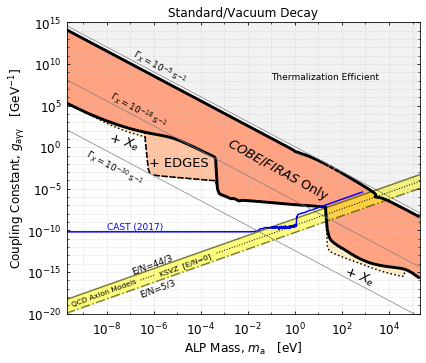

In [213]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
label_size = 12
title_size = 12
legend_size = 25
handle_length = 1.5




#levels = [-8,-4,-2,0]
levels = [-100,0]

colormap = plt.cm.Oranges #or any other colormap
colormap2 = plt.cm.Blues_r
colormap2 = colormap2
normalize = matplotlib.colors.Normalize(vmin=-10, vmax=0)


CS = ax.contour(Xf_gagg, Yf_gagg_new, Zf_gagg_no_edges,
                levels,norm=normalize,linestyles=['-','-'],colors=['k','k'],linewidths=[2.9])
CS = ax.contourf(Xf_gagg, Yf_gagg_new, Zf_gagg_no_edges,
                levels,extend='min',colors=['w','r'],alpha=0.2)

CS = ax.contour(Xf_gagg, Yf_gagg_new, Zf_gagg,
                levels,norm=normalize,linestyles=['--','--'],colors=['k','k'])
CS = ax.contourf(Xf_gagg, Yf_gagg_new, Zf_gagg,
                levels,extend='min',colors=['w','r'],alpha=0.2)




CS = ax.contour(Xf_gagg, Yf_gagg_new, Zf_gagg_with_edges_with_pca,
                levels,norm=normalize,linestyles=[':',':'],colors=['k','k'])
CS = ax.contourf(Xf_gagg, Yf_gagg_new, Zf_gagg_with_edges_with_pca,
                levels,extend='min',colors=['w','orange'],alpha=0.2)




ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)



ax.grid( b=True, which="both", alpha=0.3, linestyle='--')





ax.set_xlabel("ALP Mass, "+r'$m_\mathrm{a}\quad[\mathrm{eV}]$',size=title_size)
ax.set_ylabel("Coupling Constant, "+r'$g_\mathrm{a\gamma\gamma}\quad[\mathrm{GeV}^{-1}]$',size=title_size)
#ax.set_ylabel(label_Tau_x,size=title_size)

ax.yaxis.set_label_coords(-.11,0.5)
ax.xaxis.set_label_coords(0.5,-.09)


# im = ax.imshow(Zf, extent=[Einj_values[0], Einj_values[-1],tau_values[0],tau_values[-1]], origin='lower',
#            cmap=colormap2,norm=normalize, alpha=1.)




ax.set_xlim(mX_values[0],mX_values[-1])
#ax.set_ylim(tau_values[0],tau_values[-1])
ax.set_ylim(gagg_values[::-1][0],gagg_values[::-1][-1])


ax.patch.set_color('white') # or whatever color you like
ax.patch.set_alpha(.2)

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticklabels([r'$10^{-10}$',r'$10^{-8}$',r'$10^{-6}$',r'$10^{-4}$',r'$10^{-2}$',r'$10^{0}$',r'$10^{2}$',r'$10^{4}$'])
ax.set_yticklabels([r'$10^{-20}$',r'$10^{-15}$',r'$10^{-10}$',r'$10^{-5}$',r'$10^{0}$',r'$10^{5}$',r'$10^{10}$',r'$10^{15}$'])
CAST = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/cast_env_2016.dat')
m_cast = CAST[:,0]
gagg_cast = CAST[:,1]
ax.plot(np.log10(m_cast)[:-1],np.log10(gagg_cast)[:-1],c='blue',ls='-',lw=1.5)
#ax.fill_between(np.log10(m_cast),np.log10(gagg_cast),np.log10(5.*gagg_cast),color='blue',
#                ls='-',lw=1.)



xinj_values = 10**mX_values/xinj_to_mass
gamma = 1e-5
np.log10(g_agg(gamma,xinj_values))
ax.plot(mX_values,np.log10(g_agg(gamma,xinj_values)),label='G=1e-8',c='grey',lw=0.7)
gamma = 1e-30
np.log10(g_agg(gamma,xinj_values))
ax.plot(mX_values,np.log10(g_agg(gamma,xinj_values)),ls='-',label='G=1e-30',c='grey',lw=0.7)
gamma = 1e-18
np.log10(g_agg(gamma,xinj_values))
ax.plot(mX_values,np.log10(g_agg(gamma,xinj_values)),ls='-',label='G=1e-17',c='grey',lw=0.7)
#ax.text(0.5, 33., 'Standard Decay', fontsize=9, verticalalignment='top',
#      bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.4))



mass_in_eV = np.logspace(-11,9,100)
xinj_am = mass_in_eV/xinj_to_mass

E_over_N_minus_bla = 5./3. - 1.949
#E_over_N_minus_bla = 0.07#2. - 1.949
def f_p(m):
    return (3.4718e24/(E_over_N_minus_bla)**2.)*m**-5

tau = []
for m in mass_in_eV:
    tau.append(f_p(m))
tau_low = np.asarray(tau)
#ax.plot(mass_in_eV ,tau*1e-12,ls = '-')
gamma_low = 1./tau_low

E_over_N_minus_bla = 44./3. - 1.949
def f_p(m):
    return (3.4718e24/(E_over_N_minus_bla)**2.)*m**-5

tau = []
for m in mass_in_eV:
    tau.append(f_p(m))
tau_high = np.asarray(tau)
gamma_high = 1./tau_high

ax.plot(np.log10(mass_in_eV),np.log10(g_agg(gamma_high,xinj_am)),ls='-',c='k',alpha=0.5)
ax.plot(np.log10(mass_in_eV),np.log10(g_agg(gamma_low,xinj_am)),ls='-.',c='k',alpha=0.5)
ax.fill_between(np.log10(mass_in_eV),np.log10(g_agg(gamma_high,xinj_am)),np.log10(g_agg(gamma_low,xinj_am)),
                color='yellow',alpha=0.5)


tau_ksvz = 8.9078e23*mass_in_eV**-5
gamma_ksvz = 1./tau_ksvz

ax.plot(np.log10(mass_in_eV)[(np.log10(mass_in_eV)>-6.6) & (np.log10(mass_in_eV)<-5.9)],
        np.log10(g_agg(gamma_ksvz,xinj_am))[(np.log10(mass_in_eV)>-6.6) & (np.log10(mass_in_eV)<-5.9)],
        c='k',lw=1,ls=':')

ax.plot(np.log10(mass_in_eV)[np.log10(mass_in_eV)>-3.5],
        np.log10(g_agg(gamma_ksvz,xinj_am))[np.log10(mass_in_eV)>-3.5],
        c='k',lw=1,ls=':')

ax.text(-5.8,-12.6, r'KSVZ  [E/N=0]' , rotation = 20.2,
        fontsize=7.5, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))





ax.text(-6.65, -15.6, r'E/N=5/3' , rotation = 20.2,
         fontsize=9, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))

ax.text(-7, -12.7, r'E/N=44/3' , rotation = 20.2,
         fontsize=9, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))




ax.text(-8, -9, r'CAST (2017)' , rotation = 0,
         fontsize=9, 
          verticalalignment='top',
        color = 'blue',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))




ax.text(-9, 0, r'$\Gamma_X = 10^{-30}\,\mathrm{s}^{-1}$' , rotation = -29,
         fontsize=9, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))



ax.text(-8, 7, r'$\Gamma_X = 10^{-18}\,\mathrm{s}^{-1}$' , rotation = -29,
         fontsize=9, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))

ax.text(-7, 12, r'$\Gamma_X = 10^{-5}\,\mathrm{s}^{-1}$' , rotation = -29,
         fontsize=9, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))


ax.text(-3, 1.5, r'$COBE/FIRAS$ Only' , rotation = -29,c='k',
         fontsize=13, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))

ax.text(2, -14, r'+ $X_e$' , rotation = -20,c='k',
         fontsize=13, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))



ax.text(-8, 2., r'+ $X_e$' , rotation = -15,c='k',
         fontsize=13, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))



ax.text(-6.2, -1.1, r'+ EDGES' , rotation = 0,c='k',
         fontsize=13, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))








ax.text(-9.5,-15.7, r'QCD Axion Models' , rotation = 20.2,
        fontsize=7.5, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))


ax.text(-1, 9, r'Thermalization Efficient' , rotation = 0,c='k',
         fontsize=9, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))

xinj_values = 10**mX_values/xinj_to_mass
gamma = 1e-5
np.log10(g_agg(gamma,xinj_values))
#ax.plot(mX_values,np.log10(g_agg(gamma,xinj_values)),c='grey',label='G=1e-8')
ax.fill_between(mX_values,np.log10(g_agg(gamma,xinj_values)),15,color='grey',alpha=0.1)


#ax.text(2., 13., 'Vacuum Decay', fontsize=9, verticalalignment='top',
#      bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.4))

ax.set_ylim(-20,15)

fig.tight_layout()
#plt.legend()


name_ext = ''
case = 'lyc+reio'
if case == 'lyc+reio':
    name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
else:
    name_ext += '_no_edges'
name_ext += '_extended_run'
name_ext += '.pdf'

plt.title('Standard/Vacuum Decay')
plt.savefig(path_to_figures + '/figures_for_paper_gagg_finally' + name_ext)

In [92]:
# load the results
case = 'lyc+reio'
add_edges = 'yes'
name_ext = ''
if case == 'lyc+reio':
    name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
name_ext += '_extended_run_stim_070920'
#name_ext += '_test'
path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Einj_in_ev' + name_ext + '.txt'
Xf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Tau_X_in_s' + name_ext + '.txt'
Yf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_f_dm' + name_ext + '.txt'
Zf = np.loadtxt(path)

import math
for i in range(200):
    Zf[:,i] = [-5 if math.isnan(x) else x for x in Zf[:,i]]

tau_values = Yf[:,0]
Einj_values = Xf[0]


xinj_values = 10**Einj_values/xinj_to_Einj

mX_values = np.log10(xinj_to_mass*xinj_values)
gamma_values = np.log10(1./10**tau_values)
gagg_values = np.log10(g_agg(10**gamma_values,xinj_values))

# create an interpolating function fdm(m_X, Gamma_X):
import scipy 
f_at_einj_and_tauinj = scipy.interpolate.interp2d(Einj_values, tau_values, Zf,
                                                kind='linear',bounds_error=False,fill_value=np.nan)

In [93]:
# load the results
case = 'lyc+reio'
add_edges = 'no'
name_ext = ''
if case == 'lyc+reio':
    name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
name_ext += '_extended_run_stim_070920_no_edges'
#name_ext += '_test'
path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Einj_in_ev' + name_ext + '.txt'
Xf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Tau_X_in_s' + name_ext + '.txt'
Yf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_f_dm' + name_ext + '.txt'
Zf = np.loadtxt(path)

import math
for i in range(200):
    Zf[:,i] = [-5 if math.isnan(x) else x for x in Zf[:,i]]

tau_values = Yf[:,0]
Einj_values = Xf[0]


xinj_values = 10**Einj_values/xinj_to_Einj

mX_values = np.log10(xinj_to_mass*xinj_values)
gamma_values = np.log10(1./10**tau_values)
gagg_values = np.log10(g_agg(10**gamma_values,xinj_values))

# create an interpolating function fdm(m_X, Gamma_X):
import scipy 
f_at_einj_and_tauinj_no_edges = scipy.interpolate.interp2d(Einj_values, tau_values, Zf,
                                                kind='linear',bounds_error=False,fill_value=np.nan)

In [94]:
# save the results
add_edges = 'yes'
case = 'lyc+reio'
name_ext = ''
if case == 'lyc+reio':
     name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
name_ext += '_extended_run_stim_070920_no_edges_wpca'
#name_ext += '_test'
path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Einj_in_ev' + name_ext + '.txt'
Xf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Tau_X_in_s' + name_ext + '.txt'
Yf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_f_dm' + name_ext + '.txt'
Zf = np.loadtxt(path)

import math
for i in range(200):
    Zf[:,i] = [-5 if math.isnan(x) else x for x in Zf[:,i]]

tau_values = Yf[:,0]
Einj_values = Xf[0]


xinj_values = 10**Einj_values/xinj_to_Einj

mX_values = np.log10(xinj_to_mass*xinj_values)
gamma_values = np.log10(1./10**tau_values)
gagg_values = np.log10(g_agg(10**gamma_values,xinj_values))

# create an interpolating function fdm(m_X, Gamma_X):
import scipy 
f_at_einj_and_tauinj_with_edges_wpca = scipy.interpolate.interp2d(Einj_values, tau_values, Zf,
                                                kind='linear',bounds_error=False,fill_value=np.nan)

In [95]:
Xf_gagg = np.zeros((200, 200))
Yf_gagg = np.zeros((200, 200))
Zf_gagg = np.zeros((200, 200))
Zf_gagg_no_edges = np.zeros((200, 200))
Zf_gagg_with_edges_wpca = np.zeros((200, 200))

In [96]:
for i in range(200):
    for j in range(200):
        einj = 10**Xf[i][j]
        tau_X = 10**Yf[i][j]
        #fdm  = Zf[i][j]

        xinj = einj/xinj_to_Einj
        Xf_gagg[i][j]=np.log10(xinj_to_mass*xinj)
        gamma = 1./tau_X
        Yf_gagg[i][j]=np.log10(g_agg(gamma,xinj))
        #Zf_gagg[i][j] = fdm
    
    
    

In [97]:
# find minimum value of log10 gagg
mymin = min([min(r) for r in Yf_gagg])
print(mymin)
# find maximum value of log10 gagg
mymax = max([max(r) for r in Yf_gagg])
print(mymax)
# All the g_agg values in the range
# have been computed before:
print(gagg_values[0],gagg_values[199], len(gagg_values))
# Xf_gagg contains the masses:
# Xf_gagg = [[m_min,...,m_max],
#              :::::::::::::: ,
#            [m_min,...,m_max],]
# Yf_gagg_new has to contain the g_agg values as follows (in column):
Yf_gagg_new  = np.zeros((200,200))
for i in range(200):
    Yf_gagg_new[:,i] = gagg_values[::-1]

# then we loop over gagg and mX values and compute fdm:
for i in range(200):
    for j in range(200):
        log10mX = Xf_gagg[i][j]
        log10gagg = Yf_gagg_new[i][j]
        # compute lifetime  corresponding to mX and gagg:
        xinj = 10**log10mX/xinj_to_mass
        einj = xinj_to_Einj*xinj
        gamma  = gammaX(10**log10gagg,xinj)
        tauinj = 1./gamma
        fdm = f_at_einj_and_tauinj(np.log10(einj),np.log10(tauinj))
        Zf_gagg[i][j] = fdm
        fdm = f_at_einj_and_tauinj_no_edges(np.log10(einj),np.log10(tauinj))
        Zf_gagg_no_edges[i][j] = fdm
        fdm = f_at_einj_and_tauinj_with_edges_wpca(np.log10(einj),np.log10(tauinj))
        Zf_gagg_with_edges_wpca[i][j] = fdm






-22.891007258721398
14.608992741278602
14.608992741278602 -22.891007258721398 200


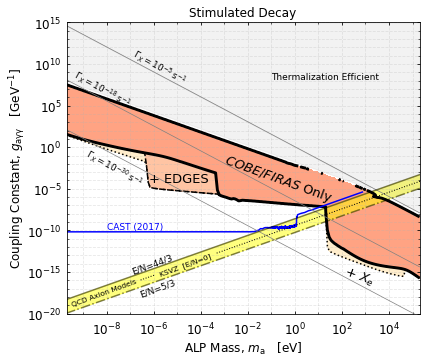

In [123]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
label_size = 12
title_size = 12
legend_size = 25
handle_length = 1.5





levels = [-100,-0]

colormap = plt.cm.Oranges #or any other colormap
colormap2 = plt.cm.Blues_r
colormap2 = colormap2
normalize = matplotlib.colors.Normalize(vmin=-10, vmax=0)

CS = ax.contour(Xf_gagg, Yf_gagg_new, Zf_gagg,
                levels,norm=normalize,linestyles=['--','--'],colors=['k','k'])
CS = ax.contourf(Xf_gagg, Yf_gagg_new, Zf_gagg,
                levels,extend='min',colors=['w','r'],alpha=0.2)


CS = ax.contour(Xf_gagg, Yf_gagg_new, Zf_gagg_no_edges,
                levels,norm=normalize,linestyles=['-','-'],colors=['k','k'],linewidths=[2.9])
CS = ax.contourf(Xf_gagg, Yf_gagg_new, Zf_gagg_no_edges,
                levels,extend='min',colors=['w','r'],alpha=0.2)

CS = ax.contour(Xf_gagg, Yf_gagg_new, Zf_gagg_with_edges_wpca,
                levels,norm=normalize,linestyles=[':',':'],colors=['k','k'])
CS = ax.contourf(Xf_gagg, Yf_gagg_new, Zf_gagg_with_edges_wpca,
                levels,extend='min',colors=['w','orange'],alpha=0.2)


ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)



ax.grid( b=True, which="both", alpha=0.3, linestyle='--')





ax.set_xlabel("ALP Mass, "+r'$m_\mathrm{a}\quad[\mathrm{eV}]$',size=title_size)
ax.set_ylabel("Coupling Constant, "+r'$g_\mathrm{a\gamma\gamma}\quad[\mathrm{GeV}^{-1}]$',size=title_size)
#ax.set_ylabel(label_Tau_x,size=title_size)

ax.yaxis.set_label_coords(-.11,0.5)
ax.xaxis.set_label_coords(0.5,-.09)





ax.set_xlim(mX_values[0],mX_values[-1])
#ax.set_ylim(tau_values[0],tau_values[-1])
ax.set_ylim(gagg_values[::-1][0],gagg_values[::-1][-1])


ax.patch.set_color('white') # or whatever color you like
ax.patch.set_alpha(.2)

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticklabels([r'$10^{-10}$',r'$10^{-8}$',r'$10^{-6}$',r'$10^{-4}$',r'$10^{-2}$',r'$10^{0}$',r'$10^{2}$',r'$10^{4}$'])
ax.set_yticklabels([r'$10^{-20}$',r'$10^{-15}$',r'$10^{-10}$',r'$10^{-5}$',r'$10^{0}$',r'$10^{5}$',r'$10^{10}$',r'$10^{15}$'])
CAST = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/cast_env_2016.dat')
m_cast = CAST[:,0]
gagg_cast = CAST[:,1]
ax.plot(np.log10(m_cast)[:-1],np.log10(gagg_cast)[:-1],c='blue',ls='-',lw=1.5)
#ax.fill_between(np.log10(m_cast),np.log10(gagg_cast),np.log10(5.*gagg_cast),color='k',ls='-',lw=0.7)



xinj_values = 10**mX_values/xinj_to_mass
gamma = 1e-5
np.log10(g_agg(gamma,xinj_values))
ax.plot(mX_values,np.log10(g_agg(gamma,xinj_values)),c='grey',label='G=1e-8',lw=0.7)
gamma = 1e-30
np.log10(g_agg(gamma,xinj_values))
ax.plot(mX_values,np.log10(g_agg(gamma,xinj_values)),c='grey',ls='-',label='G=1e-30',lw=0.7)
gamma = 1e-18
np.log10(g_agg(gamma,xinj_values))
ax.plot(mX_values,np.log10(g_agg(gamma,xinj_values)),c='grey',ls='-',label='G=1e-17',lw=0.7)
#ax.text(0.5, 33., 'Standard Decay', fontsize=9, verticalalignment='top',
#      bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.4))



mass_in_eV = np.logspace(-11,9,100)
xinj_am = mass_in_eV/xinj_to_mass

E_over_N_minus_bla = 5./3. - 1.949
#E_over_N_minus_bla = 0.07#2. - 1.949
def f_p(m):
    return (3.4718e24/(E_over_N_minus_bla)**2.)*m**-5

tau = []
for m in mass_in_eV:
    tau.append(f_p(m))
tau_low = np.asarray(tau)
#ax.plot(mass_in_eV ,tau*1e-12,ls = '-')
gamma_low = 1./tau_low

E_over_N_minus_bla = 44./3. - 1.949
def f_p(m):
    return (3.4718e24/(E_over_N_minus_bla)**2.)*m**-5

tau = []
for m in mass_in_eV:
    tau.append(f_p(m))
tau_high = np.asarray(tau)
gamma_high = 1./tau_high

ax.plot(np.log10(mass_in_eV),np.log10(g_agg(gamma_high,xinj_am)),ls='-',c='k',alpha=0.5)
ax.plot(np.log10(mass_in_eV),np.log10(g_agg(gamma_low,xinj_am)),ls='-.',c='k',alpha=0.5)
ax.fill_between(np.log10(mass_in_eV),np.log10(g_agg(gamma_high,xinj_am)),np.log10(g_agg(gamma_low,xinj_am)),
                color='yellow',alpha=0.5)
# ticks=np.arange(-10,6)
# plt.xticks(ticks)
# ticks=np.arange(5,30)
# plt.yticks(ticks)

# fig.tight_layout()


tau_ksvz = 8.9078e23*mass_in_eV**-5
gamma_ksvz = 1./tau_ksvz

ax.plot(np.log10(mass_in_eV)[(np.log10(mass_in_eV)>-6.6) & (np.log10(mass_in_eV)<-5.9)],
        np.log10(g_agg(gamma_ksvz,xinj_am))[(np.log10(mass_in_eV)>-6.6) & (np.log10(mass_in_eV)<-5.9)],
        c='k',lw=1,ls=':')

ax.plot(np.log10(mass_in_eV)[np.log10(mass_in_eV)>-3.5],
        np.log10(g_agg(gamma_ksvz,xinj_am))[np.log10(mass_in_eV)>-3.5],
        c='k',lw=1,ls=':')

ax.text(-5.8,-12.6, r'KSVZ  [E/N=0]' , rotation = 20.2,
        fontsize=7.5, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))





ax.text(-6.65, -15.6, r'E/N=5/3' , rotation = 20.2,
         fontsize=9, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))

ax.text(-7, -12.7, r'E/N=44/3' , rotation = 20.2,
         fontsize=9, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))




ax.text(-8, -9, r'CAST (2017)' , rotation = 0,
         fontsize=9, 
        color= 'blue',
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))




ax.text(-9, 0, r'$\Gamma_X = 10^{-30}\,\mathrm{s}^{-1}$' , rotation = -29,
         fontsize=9, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))



ax.text(-9.5, 9.5, r'$\Gamma_X = 10^{-18}\,\mathrm{s}^{-1}$' , rotation = -29,
         fontsize=9, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))

ax.text(-7, 12, r'$\Gamma_X = 10^{-5}\,\mathrm{s}^{-1}$' , rotation = -29,
         fontsize=9, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))



ax.text(-3.1, -0.5, r'$COBE/FIRAS$ Only' , rotation = -20,c='k',
         fontsize=13, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))



ax.text(2, -14, r'+ $X_e$' , rotation = -20,c='k',
         fontsize=13, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))





ax.text(-6.2, -2.99, r'+ EDGES' , rotation = 0,c='k',
         fontsize=13, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))









ax.text(-9.5,-15.7, r'QCD Axion Models' , rotation = 20.2,
        fontsize=7.5, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))



ax.text(-1, 9, r'Thermalization Efficient' , rotation = 0,c='k',
         fontsize=9, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='yellow',edgecolor='none', alpha=0.))

xinj_values = 10**mX_values/xinj_to_mass
gamma = 1e-5
np.log10(g_agg(gamma,xinj_values))
#ax.plot(mX_values,np.log10(g_agg(gamma,xinj_values)),c='grey',label='G=1e-8')
ax.fill_between(mX_values,np.log10(g_agg(gamma,xinj_values)),15,color='grey',alpha=0.1)

mX_valuess = mX_values[mX_values<3.2]
xinj_values = 10**mX_valuess/xinj_to_mass

gamma = 1e-5
np.log10(g_agg(gamma,xinj_values))
#ax.plot(mX_values,np.log10(g_agg(gamma,xinj_values)),c='grey',label='G=1e-8')
ax.fill_between(mX_valuess,np.log10(g_agg(gamma,xinj_values))+0.5*mX_valuess-1.8,np.log10(g_agg(gamma,xinj_values)),color='grey',alpha=0.1)




#ax.text(2., 13., 'Vacuum Decay', fontsize=9, verticalalignment='top',
#      bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.4))

ax.set_ylim(-20,15)

fig.tight_layout()
#plt.legend()


name_ext = ''
case = 'lyc+reio'
if case == 'lyc+reio':
    name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
else:
    name_ext += '_no_edges'
name_ext += '_extended_run'
name_ext += '_stimulated.pdf'

plt.title('Stimulated Decay')
plt.savefig(path_to_figures + '/figures_for_paper_gagg_finally' + name_ext)